In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense,Flatten, Dropout
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import glob
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

# VGG16 Pretrained Model

## Loading the test labels

In [ ]:
data_folder_path = "gdrive/MyDrive/GovTech VA Assessment/Assignment 1 - Training Data/"
# data_folder_path = './Assignment 1 - Training Data/'

In [ ]:
# labels_df = pd.read_csv(data_folder_path + 'labels.csv')
labels_df = pd.read_csv(data_folder_path +'labels.csv')
labels_df.loc[:,"category"] = labels_df.loc[:,"category"].astype(str)
labels_df.head()

,image,category
0,2788353.jpg,0
1,2782131.jpg,0
2,2884349.jpg,0
3,2900596.jpg,0
4,2841543.jpg,0


In [ ]:
n_classes = labels_df.category.nunique()
n_classes

5

In [ ]:
# All images have been successfully read as there are 901 items and one of which is labels.csv
labels_df.shape

(900, 2)

In [ ]:
# Checking if all the files have been read
# input_images_path = Path("./Assignment 1 - Training Data/*.jpg")
input_images_path = Path(data_folder_path+"*.jpg")
files = glob.glob(str(input_images_path))
print(len(files))

900


In [ ]:
labels_df.groupby("category").count()

,image
category,
0,100
1,200
2,200
3,200
4,200


In [ ]:
# Stratified train-validation split split
image_train, image_val, category_train, category_val = train_test_split(labels_df.image, labels_df.category, test_size=0.2, stratify=labels_df.category, random_state=42)

In [ ]:
train_df = labels_df.loc[labels_df.image.isin(image_train),:].copy()
train_df.groupby("category").count()

,image
category,
0,80
1,160
2,160
3,160
4,160


In [ ]:
val_df = labels_df.loc[labels_df.image.isin(image_val),:].copy()
val_df.groupby("category").count()

,image
category,
0,20
1,40
2,40
3,40
4,40


## Data Augmentation Testing
Generate samples for manual inspection of the Augmented image

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.2, height_shift_range=0.1,
    brightness_range=[0.5, 1.5],
    # rotation_range=30, fill_mode='nearest',
    # zoom_range=0.2
    )

Found 720 validated image filenames belonging to 5 classes.


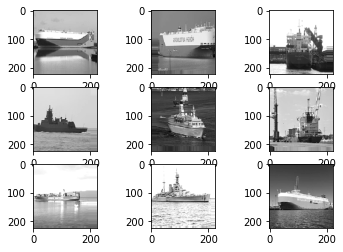

In [ ]:
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow_from_dataframe(
		dataframe=train_df,
		directory=data_folder_path,
		x_col="image",
		y_col="category",
		batch_size=9,
		seed=42,
		shuffle=True,
		class_mode="categorical",
    color_mode="grayscale",
    target_size=(224,224)):

    # create a grid of 3x3 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(224, 224), cmap=plt.get_cmap('gray'))
    # show the plot
    plt.show()
    break

## Actual Data Augmentation

In [ ]:
input_image_generators = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.2, height_shift_range=0.1,
    brightness_range=[0.5, 1.5],
    # rotation_range=30, fill_mode='nearest',
    # zoom_range=0.2
    )

In [ ]:
train_data_gen = input_image_generators.flow_from_dataframe(
		dataframe=train_df,
		directory=data_folder_path,
		x_col="image",
		y_col="category",
		# subset="training",
		batch_size=20,
		seed=42,
		shuffle=True,
		color_mode="grayscale",
		class_mode="categorical",
    target_size=(224,224))

Found 720 validated image filenames belonging to 5 classes.


In [ ]:
input_image_generators = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.2, height_shift_range=0.1,
    brightness_range=[0.5, 1.5],
    # rotation_range=30, fill_mode='nearest',
    # zoom_range=0.2
    )

In [ ]:
validation_data_gen = input_image_generators.flow_from_dataframe(
		dataframe=val_df,
		directory=data_folder_path,
		x_col="image",
		y_col="category",
		# subset="validation",
		batch_size=20,
		seed=42,
		shuffle=True,
		color_mode="grayscale",
		class_mode="categorical",
    target_size=(224,224))

Found 180 validated image filenames belonging to 5 classes.


# Build Model: Modifying the Pretrained VGG16 Model to accept greyscale images

## Loading Pretrained VGG16 Model

In [ ]:
vgg_model = VGG16(include_top=False, weights='imagenet')
print(vgg_model.summary())


58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [ ]:
#Get the dictionary of config for vgg16
vgg_config = vgg_model.get_config()
vgg_config.keys()

dict_keys(['name', 'layers', 'input_layers', 'output_layers'])

In [ ]:
vgg_config["layers"][0]["config"]["batch_input_shape"]

(None, None, None, 3)

In [ ]:
# Change the input shape to new desired shape
h, w, c = 224, 224, 1
vgg_config["layers"][0]["config"]["batch_input_shape"] = (None, h, w, c)

In [ ]:
#Create new model with the updated configuration
vgg_updated = Model.from_config(vgg_config)
print(vgg_updated.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      640       
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# First Convoluation Layer weights for the initial 3 Channels
orig_model_conv1_block1_wts = vgg_model.layers[1].get_weights()[0]
print(len(orig_model_conv1_block1_wts))
orig_model_conv1_block1_wts

3


array([[[[ 4.29470569e-01,  1.17273867e-01,  3.40129584e-02, ...,
          -1.32241577e-01, -5.33475243e-02,  7.57738389e-03],
         [ 5.50379455e-01,  2.08774377e-02,  9.88311544e-02, ...,
          -8.48205537e-02, -5.11389151e-02,  3.74943428e-02],
         [ 4.80015397e-01, -1.72696680e-01,  3.75577137e-02, ...,
          -1.27135560e-01, -5.02991639e-02,  3.48965675e-02]],

        [[ 3.73466998e-01,  1.62062630e-01,  1.70863140e-03, ...,
          -1.48207128e-01, -2.35300660e-01, -6.30356818e-02],
         [ 4.40074533e-01,  4.73412387e-02,  5.13819456e-02, ...,
          -9.88498852e-02, -2.96195745e-01, -7.04357103e-02],
         [ 4.08547401e-01, -1.70375049e-01, -4.96297423e-03, ...,
          -1.22360572e-01, -2.76450396e-01, -3.90796512e-02]],

        [[-6.13601133e-02,  1.35693997e-01, -1.15694344e-01, ...,
          -1.40158370e-01, -3.77666801e-01, -3.00509870e-01],
         [-8.13870355e-02,  4.18543853e-02, -1.01763301e-01, ...,
          -9.43124294e-02, -5.0566

In [ ]:
# Check Weights of first conv layer in the new model...
new_model_conv1_block1_wts = vgg_updated.layers[1].get_weights()[0]
print(new_model_conv1_block1_wts[:,:,0,0])

[[ 0.06456813  0.08241725 -0.10022914]
 [ 0.01545572  0.03076051 -0.06388061]
 [-0.02306664  0.0080427   0.01812397]]


In [ ]:
vgg_updated.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      640       
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Getting the name of the first convu layer
vgg_updated_config = vgg_updated.get_config()
vgg_updated_layer_names = [vgg_updated_config['layers'][x]['name'] for x in range(len(vgg_updated_config['layers']))]
first_conv_name = vgg_updated_layer_names[1]

In [ ]:
#Update weights for all layers. And for the first conv layer replace weights with average of all 3 channels. 
for layer in vgg_model.layers:
    if layer.name in vgg_updated_layer_names:
      
      #All convolutional layers and layers with weights (no input layer or any pool layers)
      if layer.get_weights() != []:  
        target_layer = vgg_updated.get_layer(layer.name)
    
        if layer.name in first_conv_name:
          weights = layer.get_weights()[0]
          biases  = layer.get_weights()[1]
          
          weights_single_channel = np.mean(weights, axis=-2).reshape(weights[:,:,-1:,:].shape)
          # Set weights for the first conv. layer        
          target_layer.set_weights([weights_single_channel, biases])  
          target_layer.trainable = False 
    
        else:
          #Set weights to all other layers.
          target_layer.set_weights(layer.get_weights())    
          target_layer.trainable = False 

In [ ]:
top_model = vgg_updated.output
top_model = Flatten(name="flatten")(top_model)
output_layer = Dense(n_classes, activation='softmax')(top_model)

In [ ]:
# Group the convolutional base and new fully-connected layers into a Model object.
final_greyscale_model = Model(inputs=vgg_updated.input, outputs=output_layer)

In [ ]:
final_greyscale_model.compile(
    optimizer= Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

# Train Model

In [ ]:
n_steps = train_data_gen.samples // 20
n_val_steps = validation_data_gen.samples // 20
n_epochs = 100

In [ ]:
checkpoint = ModelCheckpoint("vgg16_greyscale.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=n_epochs)

early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=40, verbose=1, mode='auto')
	
history = final_greyscale_model.fit(train_data_gen,
                            batch_size=20,
                            epochs=100,
                            validation_data=validation_data_gen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[checkpoint, early],
                            verbose=1)
final_greyscale_model.save_weights("vgg16_greyscale.h5")

Epoch 1/100
36/36 [==============================] - 529s 14s/step - loss: 1.6423 - accuracy: 0.2306 - val_loss: 1.5799 - val_accuracy: 0.2278
Epoch 2/100
36/36 [==============================] - 7s 181ms/step - loss: 1.5739 - accuracy: 0.2528 - val_loss: 1.5617 - val_accuracy: 0.2778
Epoch 3/100
27/36 [=====================>........] - ETA: 1s - loss: 1.5666 - accuracy: 0.2648WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 7s 204ms/step - loss: 1.5580 - accuracy: 0.2736 - val_loss: 1.5492 - val_accuracy: 0.2889
Epoch 4/100
36/36 [==============================] - 7s 182ms/step - loss: 1.5488 - accuracy: 0.3153 - val_loss: 1.5511 - val_accuracy: 0.3333
Epoch 5/100
36/36 [==============================] - 7s 182ms/step - loss: 1.5387 - accuracy: 0.3222 - val_loss: 1.5154 - val_accuracy: 0.3944
Epoch 6/100
19/36 [==============>...............] - ETA: 2s - loss: 1.5283 - accuracy: 0.3526WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 7s 181ms/step - loss: 1.5279 - accuracy: 0.3472 - val_loss: 1.5180 - val_accuracy: 0.4000
Epoch 7/100
36/36 [==============================] - 7s 181ms/step - loss: 1.5196 - accuracy: 0.4000 - val_loss: 1.5167 - val_accuracy: 0.4167
Epoch 8/100
36/36 [==============================] - 7s 182ms/step - loss: 1.5079 - accuracy: 0.4042 - val_loss: 1.5016 - val_accuracy: 0.4500
Epoch 9/100
11/36 [========>.....................] - ETA: 3s - loss: 1.4982 - accuracy: 0.4636WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 7s 183ms/step - loss: 1.4975 - accuracy: 0.4389 - val_loss: 1.4962 - val_accuracy: 0.4278
Epoch 10/100
36/36 [==============================] - 7s 183ms/step - loss: 1.4929 - accuracy: 0.4458 - val_loss: 1.4722 - val_accuracy: 0.4722
Epoch 11/100
36/36 [==============================] - 7s 182ms/step - loss: 1.4732 - accuracy: 0.4569 - val_loss: 1.4751 - val_accuracy: 0.5111
Epoch 12/100
 3/36 [=>............................] - ETA: 4s - loss: 1.4507 - accuracy: 0.5000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 7s 181ms/step - loss: 1.4689 - accuracy: 0.4667 - val_loss: 1.4717 - val_accuracy: 0.4611
Epoch 13/100
36/36 [==============================] - 7s 181ms/step - loss: 1.4648 - accuracy: 0.4875 - val_loss: 1.4625 - val_accuracy: 0.4833
Epoch 14/100
31/36 [========================>.....] - ETA: 0s - loss: 1.4644 - accuracy: 0.4774WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 7s 180ms/step - loss: 1.4627 - accuracy: 0.4736 - val_loss: 1.4463 - val_accuracy: 0.4500
Epoch 15/100
36/36 [==============================] - 7s 180ms/step - loss: 1.4545 - accuracy: 0.4639 - val_loss: 1.4376 - val_accuracy: 0.4722
Epoch 16/100
36/36 [==============================] - 7s 181ms/step - loss: 1.4408 - accuracy: 0.4903 - val_loss: 1.4320 - val_accuracy: 0.5056
Epoch 17/100
23/36 [==================>...........] - ETA: 1s - loss: 1.4335 - accuracy: 0.5196WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 7s 181ms/step - loss: 1.4278 - accuracy: 0.5056 - val_loss: 1.4280 - val_accuracy: 0.5111
Epoch 18/100
36/36 [==============================] - 7s 181ms/step - loss: 1.4275 - accuracy: 0.4944 - val_loss: 1.4125 - val_accuracy: 0.5389
Epoch 19/100
36/36 [==============================] - 7s 182ms/step - loss: 1.4122 - accuracy: 0.5236 - val_loss: 1.4269 - val_accuracy: 0.5056
Epoch 20/100
15/36 [===========>..................] - ETA: 3s - loss: 1.4045 - accuracy: 0.5133WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 7s 183ms/step - loss: 1.4138 - accuracy: 0.5083 - val_loss: 1.3996 - val_accuracy: 0.5222
Epoch 21/100
36/36 [==============================] - 7s 203ms/step - loss: 1.4019 - accuracy: 0.5236 - val_loss: 1.4100 - val_accuracy: 0.5167
Epoch 22/100
36/36 [==============================] - 7s 183ms/step - loss: 1.3877 - accuracy: 0.5208 - val_loss: 1.3765 - val_accuracy: 0.5333
Epoch 23/100
 7/36 [====>.........................] - ETA: 4s - loss: 1.3720 - accuracy: 0.5500WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 7s 184ms/step - loss: 1.3843 - accuracy: 0.5139 - val_loss: 1.3993 - val_accuracy: 0.4889
Epoch 24/100
36/36 [==============================] - 7s 181ms/step - loss: 1.3873 - accuracy: 0.5139 - val_loss: 1.3863 - val_accuracy: 0.5278
Epoch 25/100
35/36 [============================>.] - ETA: 0s - loss: 1.3748 - accuracy: 0.5400WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 7s 182ms/step - loss: 1.3727 - accuracy: 0.5389 - val_loss: 1.3675 - val_accuracy: 0.5556
Epoch 26/100
36/36 [==============================] - 7s 183ms/step - loss: 1.3693 - accuracy: 0.5375 - val_loss: 1.3769 - val_accuracy: 0.5222
Epoch 27/100
36/36 [==============================] - 7s 180ms/step - loss: 1.3576 - accuracy: 0.5389 - val_loss: 1.3861 - val_accuracy: 0.5444
Epoch 28/100
27/36 [=====================>........] - ETA: 1s - loss: 1.3582 - accuracy: 0.5259WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 7s 182ms/step - loss: 1.3587 - accuracy: 0.5236 - val_loss: 1.3450 - val_accuracy: 0.5333
Epoch 29/100
36/36 [==============================] - 7s 183ms/step - loss: 1.3648 - accuracy: 0.5097 - val_loss: 1.3653 - val_accuracy: 0.5333
Epoch 30/100
36/36 [==============================] - 7s 181ms/step - loss: 1.3530 - accuracy: 0.5403 - val_loss: 1.3420 - val_accuracy: 0.5833
Epoch 31/100
19/36 [==============>...............] - ETA: 2s - loss: 1.3329 - accuracy: 0.5421WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 7s 182ms/step - loss: 1.3290 - accuracy: 0.5361 - val_loss: 1.3244 - val_accuracy: 0.5611
Epoch 32/100
36/36 [==============================] - 7s 182ms/step - loss: 1.3313 - accuracy: 0.5111 - val_loss: 1.3299 - val_accuracy: 0.5778
Epoch 33/100
36/36 [==============================] - 7s 183ms/step - loss: 1.3297 - accuracy: 0.5486 - val_loss: 1.3363 - val_accuracy: 0.5333
Epoch 34/100
11/36 [========>.....................] - ETA: 3s - loss: 1.3342 - accuracy: 0.5227WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 7s 184ms/step - loss: 1.3199 - accuracy: 0.5514 - val_loss: 1.3206 - val_accuracy: 0.5500
Epoch 35/100
36/36 [==============================] - 7s 184ms/step - loss: 1.3106 - accuracy: 0.5694 - val_loss: 1.3310 - val_accuracy: 0.5444
Epoch 36/100
36/36 [==============================] - 7s 183ms/step - loss: 1.3194 - accuracy: 0.5486 - val_loss: 1.3078 - val_accuracy: 0.5667
Epoch 37/100
 3/36 [=>............................] - ETA: 4s - loss: 1.2985 - accuracy: 0.6000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 7s 182ms/step - loss: 1.3042 - accuracy: 0.5694 - val_loss: 1.3075 - val_accuracy: 0.5333
Epoch 38/100
36/36 [==============================] - 7s 181ms/step - loss: 1.3008 - accuracy: 0.5625 - val_loss: 1.2946 - val_accuracy: 0.5722
Epoch 39/100
31/36 [========================>.....] - ETA: 0s - loss: 1.3040 - accuracy: 0.5694WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 7s 207ms/step - loss: 1.2999 - accuracy: 0.5764 - val_loss: 1.3140 - val_accuracy: 0.5500
Epoch 40/100
36/36 [==============================] - 7s 182ms/step - loss: 1.2944 - accuracy: 0.5681 - val_loss: 1.2939 - val_accuracy: 0.5833
Epoch 41/100
36/36 [==============================] - 7s 181ms/step - loss: 1.2954 - accuracy: 0.5486 - val_loss: 1.2805 - val_accuracy: 0.5667
Epoch 42/100
23/36 [==================>...........] - ETA: 1s - loss: 1.2769 - accuracy: 0.5783WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 7s 182ms/step - loss: 1.2962 - accuracy: 0.5583 - val_loss: 1.3025 - val_accuracy: 0.5389
Epoch 43/100
36/36 [==============================] - 7s 183ms/step - loss: 1.2793 - accuracy: 0.5792 - val_loss: 1.2900 - val_accuracy: 0.5556
Epoch 44/100
36/36 [==============================] - 7s 184ms/step - loss: 1.2807 - accuracy: 0.5667 - val_loss: 1.2924 - val_accuracy: 0.5667
Epoch 45/100
15/36 [===========>..................] - ETA: 2s - loss: 1.2637 - accuracy: 0.5433WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 7s 182ms/step - loss: 1.2587 - accuracy: 0.5806 - val_loss: 1.2892 - val_accuracy: 0.5778
Epoch 46/100
36/36 [==============================] - 7s 183ms/step - loss: 1.2877 - accuracy: 0.5458 - val_loss: 1.2721 - val_accuracy: 0.5889
Epoch 47/100
36/36 [==============================] - 7s 182ms/step - loss: 1.2668 - accuracy: 0.5625 - val_loss: 1.2885 - val_accuracy: 0.5667
Epoch 48/100
 7/36 [====>.........................] - ETA: 4s - loss: 1.2914 - accuracy: 0.5214WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 7s 183ms/step - loss: 1.2519 - accuracy: 0.5806 - val_loss: 1.3036 - val_accuracy: 0.5278
Epoch 49/100
36/36 [==============================] - 7s 182ms/step - loss: 1.2542 - accuracy: 0.5750 - val_loss: 1.2647 - val_accuracy: 0.5500
Epoch 50/100
35/36 [============================>.] - ETA: 0s - loss: 1.2556 - accuracy: 0.5771WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 7s 182ms/step - loss: 1.2535 - accuracy: 0.5819 - val_loss: 1.2435 - val_accuracy: 0.5889
Epoch 51/100
36/36 [==============================] - 7s 183ms/step - loss: 1.2423 - accuracy: 0.5722 - val_loss: 1.2442 - val_accuracy: 0.5944
Epoch 52/100
36/36 [==============================] - 7s 183ms/step - loss: 1.2374 - accuracy: 0.5889 - val_loss: 1.2615 - val_accuracy: 0.5667
Epoch 53/100
27/36 [=====================>........] - ETA: 1s - loss: 1.2323 - accuracy: 0.6093WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 7s 182ms/step - loss: 1.2432 - accuracy: 0.6056 - val_loss: 1.2653 - val_accuracy: 0.5500
Epoch 54/100
36/36 [==============================] - 7s 183ms/step - loss: 1.2428 - accuracy: 0.5708 - val_loss: 1.2601 - val_accuracy: 0.5778
Epoch 55/100
36/36 [==============================] - 7s 184ms/step - loss: 1.2318 - accuracy: 0.5875 - val_loss: 1.2394 - val_accuracy: 0.5944
Epoch 56/100
19/36 [==============>...............] - ETA: 2s - loss: 1.2731 - accuracy: 0.5605WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 7s 183ms/step - loss: 1.2469 - accuracy: 0.5806 - val_loss: 1.2415 - val_accuracy: 0.5944
Epoch 57/100
36/36 [==============================] - 7s 207ms/step - loss: 1.2380 - accuracy: 0.5667 - val_loss: 1.2245 - val_accuracy: 0.5667
Epoch 58/100
36/36 [==============================] - 7s 182ms/step - loss: 1.2147 - accuracy: 0.6056 - val_loss: 1.2534 - val_accuracy: 0.5500
Epoch 59/100
11/36 [========>.....................] - ETA: 3s - loss: 1.2319 - accuracy: 0.5773WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 7s 182ms/step - loss: 1.2290 - accuracy: 0.5819 - val_loss: 1.2058 - val_accuracy: 0.5944
Epoch 60/100
36/36 [==============================] - 7s 183ms/step - loss: 1.2152 - accuracy: 0.6042 - val_loss: 1.2400 - val_accuracy: 0.5944
Epoch 61/100
36/36 [==============================] - 7s 182ms/step - loss: 1.1987 - accuracy: 0.5903 - val_loss: 1.2338 - val_accuracy: 0.6056
Epoch 62/100
 3/36 [=>............................] - ETA: 4s - loss: 1.1729 - accuracy: 0.6833WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 7s 182ms/step - loss: 1.2069 - accuracy: 0.6083 - val_loss: 1.2242 - val_accuracy: 0.5667
Epoch 63/100
36/36 [==============================] - 7s 183ms/step - loss: 1.2118 - accuracy: 0.5667 - val_loss: 1.2279 - val_accuracy: 0.6000
Epoch 64/100
31/36 [========================>.....] - ETA: 0s - loss: 1.1926 - accuracy: 0.6129WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 7s 183ms/step - loss: 1.1963 - accuracy: 0.6111 - val_loss: 1.2255 - val_accuracy: 0.5389
Epoch 65/100
36/36 [==============================] - 7s 183ms/step - loss: 1.2051 - accuracy: 0.6028 - val_loss: 1.2026 - val_accuracy: 0.5833
Epoch 66/100
36/36 [==============================] - 7s 183ms/step - loss: 1.1944 - accuracy: 0.6042 - val_loss: 1.2182 - val_accuracy: 0.5833
Epoch 67/100
23/36 [==================>...........] - ETA: 1s - loss: 1.1767 - accuracy: 0.6217WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 7s 184ms/step - loss: 1.1909 - accuracy: 0.6153 - val_loss: 1.2042 - val_accuracy: 0.5944
Epoch 68/100
36/36 [==============================] - 7s 183ms/step - loss: 1.1793 - accuracy: 0.5861 - val_loss: 1.2228 - val_accuracy: 0.5778
Epoch 69/100
36/36 [==============================] - 7s 183ms/step - loss: 1.1890 - accuracy: 0.5819 - val_loss: 1.1998 - val_accuracy: 0.6000
Epoch 70/100
15/36 [===========>..................] - ETA: 3s - loss: 1.1755 - accuracy: 0.5800WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 7s 182ms/step - loss: 1.1770 - accuracy: 0.5972 - val_loss: 1.2032 - val_accuracy: 0.6000
Epoch 71/100
36/36 [==============================] - 7s 182ms/step - loss: 1.1844 - accuracy: 0.6069 - val_loss: 1.1953 - val_accuracy: 0.6167
Epoch 72/100
36/36 [==============================] - 9s 255ms/step - loss: 1.1641 - accuracy: 0.6125 - val_loss: 1.1974 - val_accuracy: 0.6000
Epoch 73/100
 7/36 [====>.........................] - ETA: 7s - loss: 1.1602 - accuracy: 0.6071WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 10s 282ms/step - loss: 1.1725 - accuracy: 0.6083 - val_loss: 1.1784 - val_accuracy: 0.5833
Epoch 74/100
36/36 [==============================] - 8s 219ms/step - loss: 1.1770 - accuracy: 0.6111 - val_loss: 1.1936 - val_accuracy: 0.5722
Epoch 75/100
35/36 [============================>.] - ETA: 0s - loss: 1.1698 - accuracy: 0.6014WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 7s 206ms/step - loss: 1.1691 - accuracy: 0.6042 - val_loss: 1.2310 - val_accuracy: 0.5778
Epoch 76/100
36/36 [==============================] - 7s 182ms/step - loss: 1.1581 - accuracy: 0.6167 - val_loss: 1.1943 - val_accuracy: 0.5778
Epoch 77/100
36/36 [==============================] - 7s 182ms/step - loss: 1.1614 - accuracy: 0.6153 - val_loss: 1.1853 - val_accuracy: 0.5944
Epoch 78/100
27/36 [=====================>........] - ETA: 1s - loss: 1.1510 - accuracy: 0.6148WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 7s 185ms/step - loss: 1.1474 - accuracy: 0.6125 - val_loss: 1.2067 - val_accuracy: 0.5611
Epoch 79/100
36/36 [==============================] - 7s 187ms/step - loss: 1.1509 - accuracy: 0.6028 - val_loss: 1.1753 - val_accuracy: 0.5833
Epoch 80/100
36/36 [==============================] - 8s 217ms/step - loss: 1.1600 - accuracy: 0.5972 - val_loss: 1.1892 - val_accuracy: 0.6222
Epoch 81/100
19/36 [==============>...............] - ETA: 2s - loss: 1.1537 - accuracy: 0.6526WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 7s 183ms/step - loss: 1.1344 - accuracy: 0.6319 - val_loss: 1.1938 - val_accuracy: 0.6056
Epoch 82/100
36/36 [==============================] - 7s 182ms/step - loss: 1.1461 - accuracy: 0.6319 - val_loss: 1.1481 - val_accuracy: 0.6167
Epoch 83/100
36/36 [==============================] - 7s 183ms/step - loss: 1.1266 - accuracy: 0.6458 - val_loss: 1.1920 - val_accuracy: 0.5833
Epoch 84/100
11/36 [========>.....................] - ETA: 3s - loss: 1.1520 - accuracy: 0.5955WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 7s 184ms/step - loss: 1.1370 - accuracy: 0.6361 - val_loss: 1.1657 - val_accuracy: 0.6000
Epoch 85/100
36/36 [==============================] - 7s 182ms/step - loss: 1.1398 - accuracy: 0.6194 - val_loss: 1.1905 - val_accuracy: 0.5778
Epoch 86/100
36/36 [==============================] - 7s 202ms/step - loss: 1.1435 - accuracy: 0.5986 - val_loss: 1.1531 - val_accuracy: 0.6056
Epoch 87/100
 3/36 [=>............................] - ETA: 4s - loss: 1.0111 - accuracy: 0.7333WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 7s 182ms/step - loss: 1.1295 - accuracy: 0.6208 - val_loss: 1.1729 - val_accuracy: 0.5667
Epoch 88/100
36/36 [==============================] - 7s 181ms/step - loss: 1.1325 - accuracy: 0.6347 - val_loss: 1.1704 - val_accuracy: 0.6167
Epoch 89/100
31/36 [========================>.....] - ETA: 0s - loss: 1.1281 - accuracy: 0.6081WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 7s 182ms/step - loss: 1.1296 - accuracy: 0.6153 - val_loss: 1.1322 - val_accuracy: 0.5889
Epoch 90/100
36/36 [==============================] - 7s 184ms/step - loss: 1.1294 - accuracy: 0.6236 - val_loss: 1.2120 - val_accuracy: 0.5556
Epoch 91/100
36/36 [==============================] - 7s 183ms/step - loss: 1.1183 - accuracy: 0.6264 - val_loss: 1.1556 - val_accuracy: 0.6556
Epoch 92/100
23/36 [==================>...........] - ETA: 1s - loss: 1.0859 - accuracy: 0.6478WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 9s 248ms/step - loss: 1.1113 - accuracy: 0.6319 - val_loss: 1.1496 - val_accuracy: 0.6389
Epoch 93/100
36/36 [==============================] - 7s 182ms/step - loss: 1.1172 - accuracy: 0.6181 - val_loss: 1.1417 - val_accuracy: 0.5889
Epoch 94/100
36/36 [==============================] - 7s 183ms/step - loss: 1.1113 - accuracy: 0.6236 - val_loss: 1.1729 - val_accuracy: 0.5667
Epoch 95/100
15/36 [===========>..................] - ETA: 3s - loss: 1.0803 - accuracy: 0.6600WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 7s 182ms/step - loss: 1.1111 - accuracy: 0.6458 - val_loss: 1.1281 - val_accuracy: 0.6444
Epoch 96/100
36/36 [==============================] - 7s 183ms/step - loss: 1.1264 - accuracy: 0.6278 - val_loss: 1.1266 - val_accuracy: 0.5889
Epoch 97/100
36/36 [==============================] - 7s 183ms/step - loss: 1.1011 - accuracy: 0.6250 - val_loss: 1.1396 - val_accuracy: 0.6111
Epoch 98/100
 7/36 [====>.........................] - ETA: 4s - loss: 1.0948 - accuracy: 0.6071WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 7s 182ms/step - loss: 1.1162 - accuracy: 0.6361 - val_loss: 1.1579 - val_accuracy: 0.6056
Epoch 99/100
36/36 [==============================] - 7s 184ms/step - loss: 1.0940 - accuracy: 0.6556 - val_loss: 1.1333 - val_accuracy: 0.6056
Epoch 100/100
35/36 [============================>.] - ETA: 0s - loss: 1.1074 - accuracy: 0.6443WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 7s 183ms/step - loss: 1.1040 - accuracy: 0.6486 - val_loss: 1.1585 - val_accuracy: 0.5833
